# Labelling data and comparing classification algorithms

In [ ]:
"""Labelling data and comparing classification algorithms

"""

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

In [ ]:
# import data
df = pd.read_csv('data/SCADA_and_downtime.csv', skip_blank_lines=True)

In [ ]:
# list of turbines to plot
list1 = [1]
# list1 = list(df['turbine_id'].unique())
# sort turbines in ascending order
# list1 = sorted(list1, key=int)
# list of categories to plot
list2 = [10, 11]
# list2 = list(df['TurbineCategory_id'].unique())
# list2 = [g for g in list2 if g >= 0]
# sort categories in ascending order
# list2 = sorted(list2, key=int)
# categories to remove from plot
# list2 = [m for m in list2 if m not in (1, 12, 13, 14, 15, 17, 21, 22)]

Results for Turbine 1 with Turbine Category 11
LR: 0.682084 (0.006069)
LDA: 0.765452 (0.005270)
KNN5: 0.889947 (0.002742)
KNN15: 0.888914 (0.003590)
DT: 0.851390 (0.003076)
RF: 0.899010 (0.002075)
NB: 0.683200 (0.006298)
MLP: 0.890631 (0.004285)


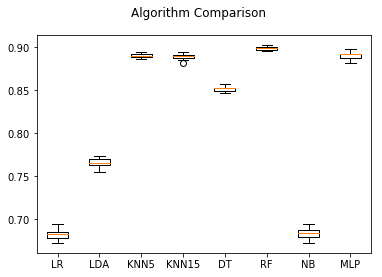

In [2]:
for x in list1:
    # filter only data for turbine x
    dfx = df[(df['turbine_id'] == x)].copy()

    for y in list2:
        # copying fault to new column (mins) (fault when turbine category id
        # is y)
        def f(c):
            if c['TurbineCategory_id'] == y:
                return 0
            else:
                return 1
        dfx['mins'] = dfx.apply(f, axis=1)

        # sort values by timestamp in descending order
        dfx = dfx.sort_values(by='timestamp', ascending=False)

        # reset index
        dfx.reset_index(drop=True, inplace=True)

        # assigning value to first cell if it's not 0
        if dfx.loc[0, 'mins'] == 0:
            dfx.set_value(0, 'mins', 0)
        else:
            dfx.set_value(0, 'mins', 999999999)

        # using previous value's row to evaluate time
        for i, e in enumerate(dfx['mins']):
            if e == 1:
                dfx.at[i, 'mins'] = dfx.at[i - 1, 'mins'] + 10

        # sort in ascending order
        dfx = dfx.sort_values(by='timestamp')

        # reset index
        dfx.reset_index(drop=True, inplace=True)

        # convert to hours and round to nearest hour
        dfx['hours'] = dfx['mins'].astype(np.int64)
        dfx['hours'] = dfx['hours']/60
        dfx['hours'] = round(dfx['hours']).astype(np.int64)

        # > 48 hours - label as normal (9999)
        def f1(c):
            if c['hours'] > 48:
                return 9999
            else:
                return c['hours']
        dfx['hours'] = dfx.apply(f1, axis=1)

        # filter out curtailment - curtailed when turbine is pitching outside
        # 0deg <= normal <= 3.5deg
        def f2(c):
            if 0 <= c['pitch'] <= 3.5 or c['hours'] != 9999 or (
                    (c['pitch'] > 3.5 or c['pitch'] < 0) and (
                        c['ap_av'] <= (.1 * dfx['ap_av'].max()) or
                        c['ap_av'] >= (.9 * dfx['ap_av'].max()))):
                return 'normal'
            else:
                return 'curtailed'
        dfx['curtailment'] = dfx.apply(f2, axis=1)

        # filter unusual readings, i.e. for normal operation, power <= 0 in
        # operating wind speeds, power > 100 before cut-in, runtime < 600 and
        # other downtime categories
        def f3(c):
            if c['hours'] == 9999 and ((
                        3 < c['ws_av'] < 25 and (
                            c['ap_av'] <= 0 or
                            c['runtime'] < 600 or
                            c['EnvironmentalCategory_id'] > 1 or
                            c['GridCategory_id'] > 1 or
                            c['InfrastructureCategory_id'] > 1 or
                            c['AvailabilityCategory_id'] == 2 or
                            12 <= c['TurbineCategory_id'] <= 15 or
                            21 <= c['TurbineCategory_id'] <= 22)) or
                    (c['ws_av'] < 3 and c['ap_av'] > 100)):
                # remove unusual readings, i.e., zero power at operating wind
                # speeds, power > 0 before cut-in ...
                return 'unusual'
            else:
                return 'normal'
        dfx['unusual'] = dfx.apply(f3, axis=1)

        # round to 6 hour intervals
        def f4(c):
            if 1 <= c['hours'] <= 6:
                return 6
            elif 7 <= c['hours'] <= 12:
                return 12
            elif 13 <= c['hours'] <= 18:
                return 18
            elif 19 <= c['hours'] <= 24:
                return 24
            elif 25 <= c['hours'] <= 30:
                return 30
            elif 31 <= c['hours'] <= 36:
                return 36
            elif 37 <= c['hours'] <= 42:
                return 42
            elif 43 <= c['hours'] <= 48:
                return 48
            else:
                return c['hours']
        dfx['hours6'] = dfx.apply(f4, axis=1)

        # change label for unusual and curtailed data
        def f5(c):
            if c['unusual'] == 'unusual' or c['curtailment'] == 'curtailed':
                return -9999
            else:
                return c['hours6']
        dfx['hours_%s' % y] = dfx.apply(f5, axis=1)

        # drop unnecessary columns
        dfx = dfx.drop('hours6', axis=1)
        dfx = dfx.drop('hours', axis=1)
        dfx = dfx.drop('mins', axis=1)
        dfx = dfx.drop('curtailment', axis=1)
        dfx = dfx.drop('unusual', axis=1)

    df2 = dfx[[
        'ap_av', 'ws_av', 'wd_av', 'pitch', 'ap_max', 'ap_dev',
        'reactive_power', 'rs_av', 'gen_sp', 'nac_pos', 'hours_11']].copy()
    df2 = df2.dropna()

    # splitting data set
    features = [
        'ap_av', 'ws_av', 'wd_av', 'pitch', 'ap_max', 'ap_dev',
        'reactive_power', 'rs_av', 'gen_sp', 'nac_pos']
    X = df2[features]
    Y = df2['hours_11']
    Xn = preprocessing.normalize(X)
    validation_size = .20
    seed = 7
    X_train, X_validation, Y_train, Y_validation = (
        model_selection.train_test_split(
            Xn, Y, test_size=validation_size, random_state=seed))

    models = []
    models.append(('LR', LogisticRegression(class_weight='balanced')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN5', KNeighborsClassifier()))
    models.append(('KNN15', KNeighborsClassifier(n_neighbors=15)))
    models.append(('DT', DecisionTreeClassifier(class_weight='balanced')))
    models.append(('RF', RandomForestClassifier(class_weight='balanced')))
    models.append(('NB', GaussianNB()))
    models.append(('MLP', MLPClassifier()))

    # evaluate each model in turn
    results = []
    names = []
    msg1 = 'Results for Turbine %s' % x + ' with Turbine Category %s' % y
    print(msg1)
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(
            model, X_train, Y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
        print(msg)

    # compare algorithms
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [14]:
clf2 = RandomForestClassifier(class_weight='balanced')
clf2.fit(X_train, Y_train)
predictions2 = clf2.predict(X_validation)
print(accuracy_score(Y_validation, predictions2))
print(confusion_matrix(Y_validation, predictions2))
print(classification_report(Y_validation, predictions2))

0.903127204326
[[  369     5     4     1     1     0     0     0     3    37]
 [    3    57    13     1     1     0     2     0     0   202]
 [    5     9    60     2     0     0     0     0     1   160]
 [    1     7     6    50     3     0     0     4     0   140]
 [    0     1     4     3    22     0     1     1     2   124]
 [    0     0     3     0     5    33     2     2     2    98]
 [    0     1     0     0     2     3    31     1     0   124]
 [    4     1     0     3     0     1     1    19     3   114]
 [    1     0     3     1     0     0     1     3    22   107]
 [    4    22   356     9     6     6     7     3     2 14701]]
             precision    recall  f1-score   support

          0       0.95      0.88      0.91       420
          6       0.55      0.20      0.30       279
         12       0.13      0.25      0.17       237
         18       0.71      0.24      0.36       211
         24       0.55      0.14      0.22       158
         30       0.77      0.23   

In [15]:
clf = KNeighborsClassifier()
clf.fit(X_train, Y_train)
predictions = clf.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.913825534917
[[  361     6     2     3     0     0     1     0     0    47]
 [    6    28     7     3     5     1     2     1     0   226]
 [    7     9    40     4     3     0     0     0     0   174]
 [    3     9    11    40     3     1     0     2     1   141]
 [    1     0     0     7    15     3     0     2     0   130]
 [    3     3     2     1     3    28     3     2     1    99]
 [    2     2     0     2     1     3    30     1     1   120]
 [    4     0     2     6     0     1     4    23     3   103]
 [    2     0     2     1     1     0     1     1    19   111]
 [   15    36    19    21    13    15    16    11     8 14962]]
             precision    recall  f1-score   support

          0       0.89      0.86      0.88       420
          6       0.30      0.10      0.15       279
         12       0.47      0.17      0.25       237
         18       0.45      0.19      0.27       211
         24       0.34      0.09      0.15       158
         30       0.54      0.19   

In [4]:
print(dfx.groupby('hours6').size())

hours6
0         2204
6         1719
12        1289
18        1070
24         913
30         787
36         756
42         727
48         684
9999    121179
dtype: int64
